Shape: (2919, 13)
Columns: ['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'LotConfig', 'BldgType', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'Exterior1st', 'BsmtFinSF2', 'TotalBsmtSF', 'SalePrice']

Categorical Features: ['MSZoning', 'LotConfig', 'BldgType', 'Exterior1st']
Numerical Features: ['MSSubClass', 'LotArea', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF2', 'TotalBsmtSF']

📊 Model Performance:
RMSE: 54022.741603355484
R² Score: 0.6195133646847626


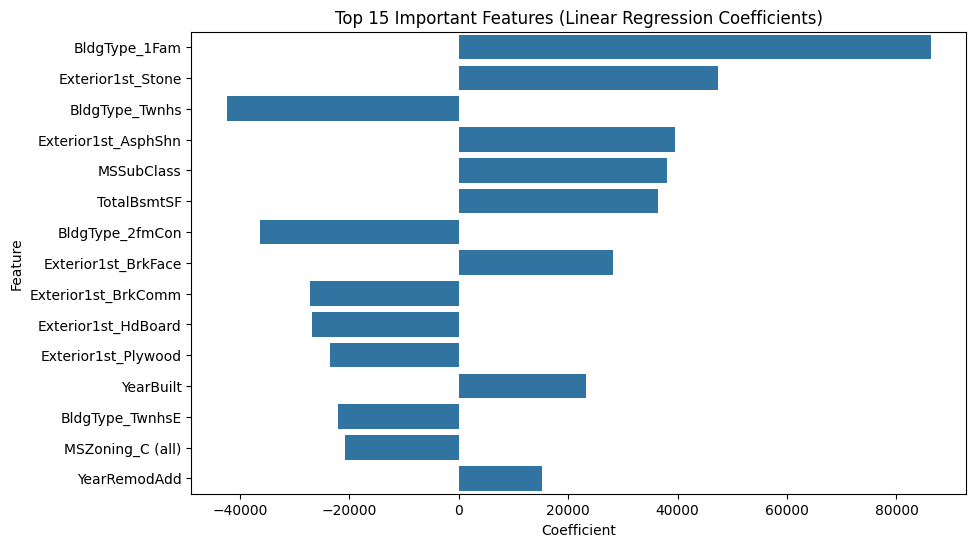


📈 Polynomial Regression Performance:
RMSE: 63642.819921386654
R² Score: 0.4719379048376324


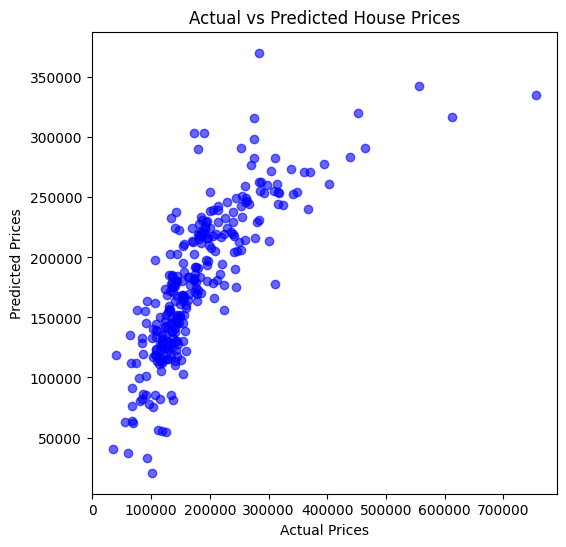

In [1]:
# ============================
# House Price Prediction (Your Dataset)
# ============================

# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

# -----------------------------
# 2. Load Data
# -----------------------------
file_path = "HousePricePrediction.xlsx"
data = pd.read_excel(file_path)

print("Shape:", data.shape)
print("Columns:", data.columns.tolist())

# -----------------------------
# 3. Preprocessing
# -----------------------------
# Drop ID column
data = data.drop(columns=["Id"])

# Split into train (with SalePrice) and test (SalePrice missing)
train_data = data[data["SalePrice"].notnull()].copy()
test_data = data[data["SalePrice"].isnull()].drop(columns=["SalePrice"]).copy()

# Features and Target
X = train_data.drop(columns=["SalePrice"])
y = train_data["SalePrice"]

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

print("\nCategorical Features:", categorical_cols)
print("Numerical Features:", numerical_cols)

# -----------------------------
# 4. Pipeline for Preprocessing
# -----------------------------
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# -----------------------------
# 5. Train-Test Split
# -----------------------------
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# 6. Build Model Pipeline
# -----------------------------
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_valid)

# -----------------------------
# 7. Evaluation
# -----------------------------
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
r2 = r2_score(y_valid, y_pred)

print("\n📊 Model Performance:")
print("RMSE:", rmse)
print("R² Score:", r2)

# -----------------------------
# 8. Feature Importance
# -----------------------------
# Extract coefficients with feature names
encoded_features = model.named_steps['preprocessor'].transformers_[1][1]['encoder'].get_feature_names_out(categorical_cols)
all_features = numerical_cols + encoded_features.tolist()
coefficients = model.named_steps['regressor'].coef_

coef_df = pd.DataFrame({"Feature": all_features, "Coefficient": coefficients})
coef_df = coef_df.sort_values(by="Coefficient", key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Coefficient", y="Feature", data=coef_df.head(15))
plt.title("Top 15 Important Features (Linear Regression Coefficients)")
plt.show()

# -----------------------------
# 9. Polynomial Regression (Optional)
# -----------------------------
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(preprocessor.fit_transform(X))

X_train_p, X_valid_p, y_train_p, y_valid_p = train_test_split(
    X_poly, y, test_size=0.2, random_state=42
)

poly_model = LinearRegression()
poly_model.fit(X_train_p, y_train_p)

y_pred_p = poly_model.predict(X_valid_p)

rmse_poly = np.sqrt(mean_squared_error(y_valid_p, y_pred_p))
r2_poly = r2_score(y_valid_p, y_pred_p)

print("\n📈 Polynomial Regression Performance:")
print("RMSE:", rmse_poly)
print("R² Score:", r2_poly)

# -----------------------------
# 10. Visualization: Actual vs Predicted
# -----------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_valid, y_pred, alpha=0.6, color="blue")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices")
plt.show()


